In [38]:
!pip install pycaret

In [39]:
##import what we need in order to perceed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.neighbors import KNeighborsRegressor
import scipy.stats
from pycaret.regression import setup, compare_models
from sklearn.model_selection import KFold, cross_val_score

from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge, HuberRegressor, Ridge, OrthogonalMatchingPursuit
from sklearn import linear_model

import optuna

In [40]:
train0 = pd.read_csv('train.csv')
test0 = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [41]:
target = train0['SalePrice']
test_ids = test0['Id']

train1 = train0.drop(['Id', 'SalePrice'], axis=1)
test1 = test0.drop('Id', axis=1)

data = pd.concat([train1, test1], axis=0).reset_index(drop=True)
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2915,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2916,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2917,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [42]:
###Correct the data type of the variables

In [43]:
data['MSSubClass'] = data['MSSubClass'].astype(str)

In [44]:
####Cleaning
##first make the difference between null values as missing values or as a meaning
##Using the mode to fill the categorical variable

In [45]:
# Impute using a constant value
for column in [
    'Alley',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PoolQC',
    'Fence',
    'MiscFeature'
]:
    data[column] = data[column].fillna("None")

# Impute using the column mode
for column in [
    'MSZoning',
    'Utilities',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Electrical',
    'KitchenQual',
    'Functional',
    'SaleType'
]:
    data[column] = data[column].fillna(data[column].mode()[0])

In [46]:
##we will start cleaning the numerical data by filling missing values, using knn amputation

In [47]:
def knn_impute(df, na_target):
    df = df.copy()
    
    numeric_df = df.select_dtypes(np.number)
    non_na_columns = numeric_df.loc[: ,numeric_df.isna().sum() == 0].columns
    
    y_train = numeric_df.loc[numeric_df[na_target].isna() == False, na_target]
    X_train = numeric_df.loc[numeric_df[na_target].isna() == False, non_na_columns]
    X_test = numeric_df.loc[numeric_df[na_target].isna() == True, non_na_columns]
    
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    df.loc[df[na_target].isna() == True, na_target] = y_pred
    
    return df

In [48]:
for column in [
    'LotFrontage',
    'MasVnrArea',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'BsmtUnfSF',
    'TotalBsmtSF',
    'BsmtFullBath',
    'BsmtHalfBath',
    'GarageYrBlt',
    'GarageCars',
    'GarageArea'
]:
    data = knn_impute(data, column)

In [49]:
##take column names of the numeric features
##see skew for each column
##log transform for skewed features

In [50]:
data["SqFtPerRoom"] = data["GrLivArea"] / (data["TotRmsAbvGrd"] +
                                                       data["FullBath"] +
                                                       data["HalfBath"] +
                                                       data["KitchenAbvGr"])

data['Total_Home_Quality'] = data['OverallQual'] + data['OverallCond']

data['Total_Bathrooms'] = (data['FullBath'] + (0.5 * data['HalfBath']) +
                               data['BsmtFullBath'] + (0.5 * data['BsmtHalfBath']))

data["HighQualSF"] = data["1stFlrSF"] + data["2ndFlrSF"]

In [51]:
skew_df = pd.DataFrame(data.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(data[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)
skew_df

,Feature,Skew,Absolute Skew,Skewed
0,LotFrontage,1.340751,1.340751,True
1,LotArea,12.822431,12.822431,True
2,OverallQual,0.197110,0.197110,False
3,OverallCond,0.570312,0.570312,True
4,YearBuilt,-0.599806,0.599806,True
5,YearRemodAdd,-0.451020,0.451020,False
6,MasVnrArea,2.603682,2.603682,True
7,BsmtFinSF1,1.425516,1.425516,True
8,BsmtFinSF2,4.146111,4.146111,True
9,BsmtUnfSF,0.919322,0.919322,True


In [52]:
for column in skew_df.query("Skewed == True")['Feature'].values:
    data[column] = np.log1p(data[column])

In [53]:
##encoding the categoricals

data = pd.get_dummies(data)

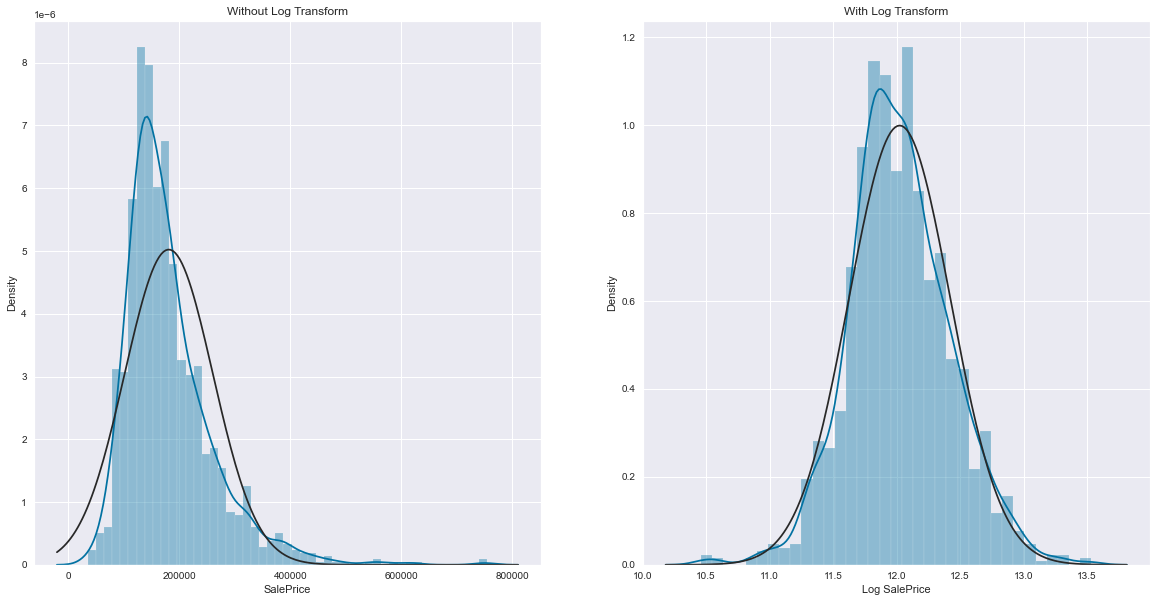

In [54]:
##unskew the dependent variable

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.distplot(target, kde=True, fit=scipy.stats.norm)
plt.title("Without Log Transform")

plt.subplot(1, 2, 2)
sns.distplot(np.log(target), kde=True, fit=scipy.stats.norm)
plt.xlabel("Log SalePrice")
plt.title("With Log Transform")

plt.show()

In [55]:
log_target = np.log(target)

In [56]:
train_final = data.loc[:train0.index.max(), :].copy()
test_final = data.loc[train0.index.max() + 1:, :].reset_index(drop=True).copy()

In [57]:
##Linear Regression
model = linear_model.LinearRegression()

In [58]:
model.fit(train_final, log_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [59]:
print("Accuracy --> ", model.score(train_final, log_target)*100)

Accuracy -->  94.83435046356703


In [60]:
r_squared1 = model.score(train_final, log_target)

In [61]:
print(r_squared1)

0.9483435046356703


In [ ]:
_ = setup(data=pd.concat([train_final, log_target], axis=1), target='SalePrice')

In [ ]:
##comparison of regressors
compare_models()

In [ ]:
catboost_params = {
    'iterations': 6000,
    'learning_rate': 0.005,
    'depth': 4,
    'l2_leaf_reg': 1,
    'eval_metric':'RMSE',
    'early_stopping_rounds': 200,
    'random_seed': 42
}

In [ ]:
##CatBoost regressor
modelc = CatBoostRegressor(**catboost_params, verbose=0)

In [ ]:
modelc.fit(train_final, log_target)

In [ ]:
print("Accuracy --> ", modelc.score(train_final, log_target)*100)

In [ ]:
r_squared2 = modelc.score(train_final, log_target)

In [30]:
print(r_squared2)

0.976362407318641


In [31]:
br_params = {
    'n_iter': 304,
    'tol': 0.16864712769300896,
    'alpha_1': 5.589616542154059e-07,
    'alpha_2': 9.799343618469923,
    'lambda_1': 1.7735725582463822,
    'lambda_2': 3.616928181181732e-06
}

In [32]:
##Bayesian Ridge
modelbr = BayesianRidge(**br_params)

In [33]:
modelbr.fit(train_final, log_target)

BayesianRidge(alpha_1=5.589616542154059e-07, alpha_2=9.799343618469923,
              alpha_init=None, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1.7735725582463822,
              lambda_2=3.616928181181732e-06, lambda_init=None, n_iter=304,
              normalize=False, tol=0.16864712769300896, verbose=False)

In [34]:
print("Accuracy --> ", modelbr.score(train_final, log_target)*100)

Accuracy -->  92.26845614884171


In [35]:
r_squared3 = modelbr.score(train_final, log_target)

In [36]:
print(r_squared3)

0.922684561488417
